In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================
# 1. Create CSV from folders
# ==================
def create_csv_from_folders(base_dir, csv_path):
    """
    Create CSV directly from ECG/ and NON-ECG/ folders
    """
    data = []

    # ECG images (label = 1)
    ecg_folder = os.path.join(base_dir, 'ECG')
    for fname in os.listdir(ecg_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            data.append({
                'filename': fname,
                'label': 1,
                'folder': 'ECG'
            })

    # NON-ECG images (label = 0)
    non_ecg_folder = os.path.join(base_dir, 'NON-ECG')
    for fname in os.listdir(non_ecg_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            data.append({
                'filename': fname,
                'label': 0,
                'folder': 'NON-ECG'
            })

    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    print(f"ECG images: {(df['label'] == 1).sum()}")
    print(f"NON-ECG images: {(df['label'] == 0).sum()}")

    # Create 80/20 train/val split
    train, val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    train['split'] = 'train'
    val['split'] = 'val'

    df_final = pd.concat([train, val], ignore_index=True)
    df_final.to_csv(csv_path, index=False)

    print(f"\n✅ CSV created: {csv_path}")
    print(f"Train: {(df_final['split'] == 'train').sum()}")
    print(f"Val:   {(df_final['split'] == 'val').sum()}\n")

    return df_final

# ==================
# 2. Dataset Class
# ==================
class ECGDataset(Dataset):
    def __init__(self, csv_path, base_dir, split='train', transform=None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['split'] == split]
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_dir, row['folder'], row['filename'])

        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224))

        label = int(row['label'])

        if self.transform:
            img = self.transform(img)

        return img, label

# ==================
# 3. Create CSV and Datasets
# ==================
base_dir = '/content/drive/MyDrive/GNN-BC'  # UPDATE THIS PATH
csv_path = 'ecg_annotations.csv'

# Create CSV if it doesn't exist
if not os.path.exists(csv_path):
    df = create_csv_from_folders(base_dir, csv_path)
else:
    print(f"✅ CSV already exists: {csv_path}")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
print("Creating datasets...")
train_dataset = ECGDataset(csv_path, base_dir, split='train', transform=train_transform)
val_dataset = ECGDataset(csv_path, base_dir, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Val samples: {len(val_dataset)}")


Total images: 407
ECG images: 208
NON-ECG images: 199

✅ CSV created: ecg_annotations.csv
Train: 325
Val:   82

Creating datasets...
✅ Train samples: 325
✅ Val samples: 82


In [4]:
!pip install torch


Device: cuda
CSV path: /content/drive/MyDrive/GNN-BC/ecg_annotations.csv
Base dir: /content/drive/MyDrive/GNN-BC
CSV exists: True
Base dir exists: True

Creating datasets...
✅ Train samples: 325
✅ Val samples: 82

Loading MobileNetV2 with transfer learning...
Total params: 2,225,153 | Trainable: 887,361

🏋️  TRAINING STARTED

Epoch  1/30 | Train Loss: 0.6777 Acc: 0.5815 | Val Loss: 0.6526 Acc: 0.6463
                 ✅ Best model saved!
Epoch  2/30 | Train Loss: 0.6578 Acc: 0.6369 | Val Loss: 0.6323 Acc: 0.7439
                 ✅ Best model saved!
Epoch  3/30 | Train Loss: 0.6361 Acc: 0.7323 | Val Loss: 0.6078 Acc: 0.7561
                 ✅ Best model saved!
Epoch  4/30 | Train Loss: 0.6199 Acc: 0.7815 | Val Loss: 0.5839 Acc: 0.8049
                 ✅ Best model saved!
Epoch  5/30 | Train Loss: 0.5923 Acc: 0.8492 | Val Loss: 0.5551 Acc: 0.8049
                 ✅ Best model saved!
Epoch  6/30 | Train Loss: 0.5710 Acc: 0.8738 | Val Loss: 0.5444 Acc: 0.8293
                 ✅ Best model s

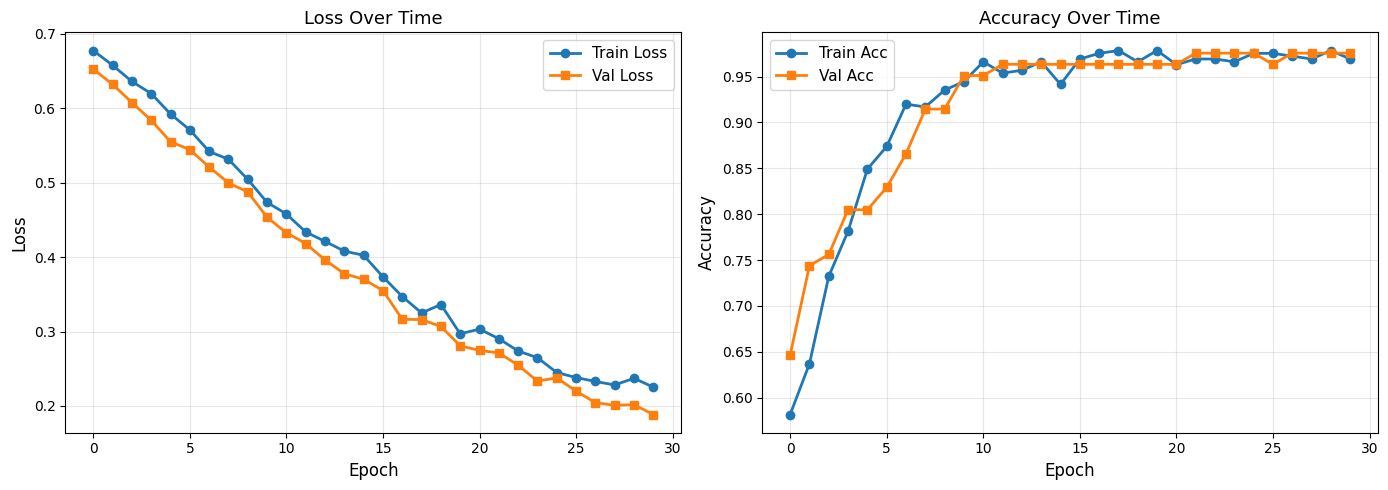


📈 Final Results:
   Best Val Loss: 0.1885
   Final Val Acc: 0.9756
   ✅ Model saved: best_mobilenetv2.pt


In [8]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ==================
# 1. Dataset Class
# ==================
class ECGDataset(Dataset):
    def __init__(self, csv_path, base_dir, split='train', transform=None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['split'] == split]
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_dir, row['folder'], row['filename'])

        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return random image if file not found
            img = Image.new('RGB', (224, 224))

        label = int(row['label'])

        if self.transform:
            img = self.transform(img)

        return img, label

# ==================
# 2. Transforms
# ==================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==================
# 3. Create Datasets (UPDATE PATH HERE)
# ==================
csv_path = '/content/drive/MyDrive/GNN-BC/ecg_annotations.csv'
base_dir = '/content/drive/MyDrive/GNN-BC'  # UPDATE THIS PATH

print(f"CSV path: {csv_path}")
print(f"Base dir: {base_dir}")
print(f"CSV exists: {os.path.exists(csv_path)}")
print(f"Base dir exists: {os.path.exists(base_dir)}")

print("\nCreating datasets...")
train_dataset = ECGDataset(csv_path, base_dir, split='train', transform=train_transform)
val_dataset = ECGDataset(csv_path, base_dir, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Val samples: {len(val_dataset)}")

# ==================
# 4. Load Model
# ==================
print("\nLoading MobileNetV2 with transfer learning...")
model = models.mobilenet_v2(weights='DEFAULT')

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[1] = nn.Linear(model.last_channel, 1)

# Unfreeze last layers
for param in model.features[-2:].parameters():
    param.requires_grad = True

model = model.to(device)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Total params: {total:,} | Trainable: {trainable:,}")

# ==================
# 5. Training Setup
# ==================
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-5,
    weight_decay=1e-4
)
# FIX: Remove verbose=True
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# ==================
# 6. Training Loop
# ==================
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(val_loader), correct / total

# Training
num_epochs = 30
best_val_loss = float('inf')
patience = 6
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\n" + "="*70)
print("🏋️  TRAINING STARTED")
print("="*70 + "\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:2d}/{num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_mobilenetv2.pt')
        print(f"                 ✅ Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

print("\n" + "="*70)
print("✅ TRAINING COMPLETE")
print("="*70)

# Plot results
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
plt.plot(val_losses, label='Val Loss', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.title('Loss Over Time', fontsize=13)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o', linewidth=2)
plt.plot(val_accs, label='Val Acc', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.title('Accuracy Over Time', fontsize=13)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
print("📊 Training plot saved: training_results.png")
plt.show()

print(f"\n📈 Final Results:")
print(f"   Best Val Loss: {min(val_losses):.4f}")
print(f"   Final Val Acc: {val_accs[-1]:.4f}")
print(f"   ✅ Model saved: best_mobilenetv2.pt")


Loading model...
✅ Model loaded




Saving HB(1).jpg to HB(1).jpg
File: HB(1).jpg
  Prediction: ECG ✅
  Confidence: 0.7097



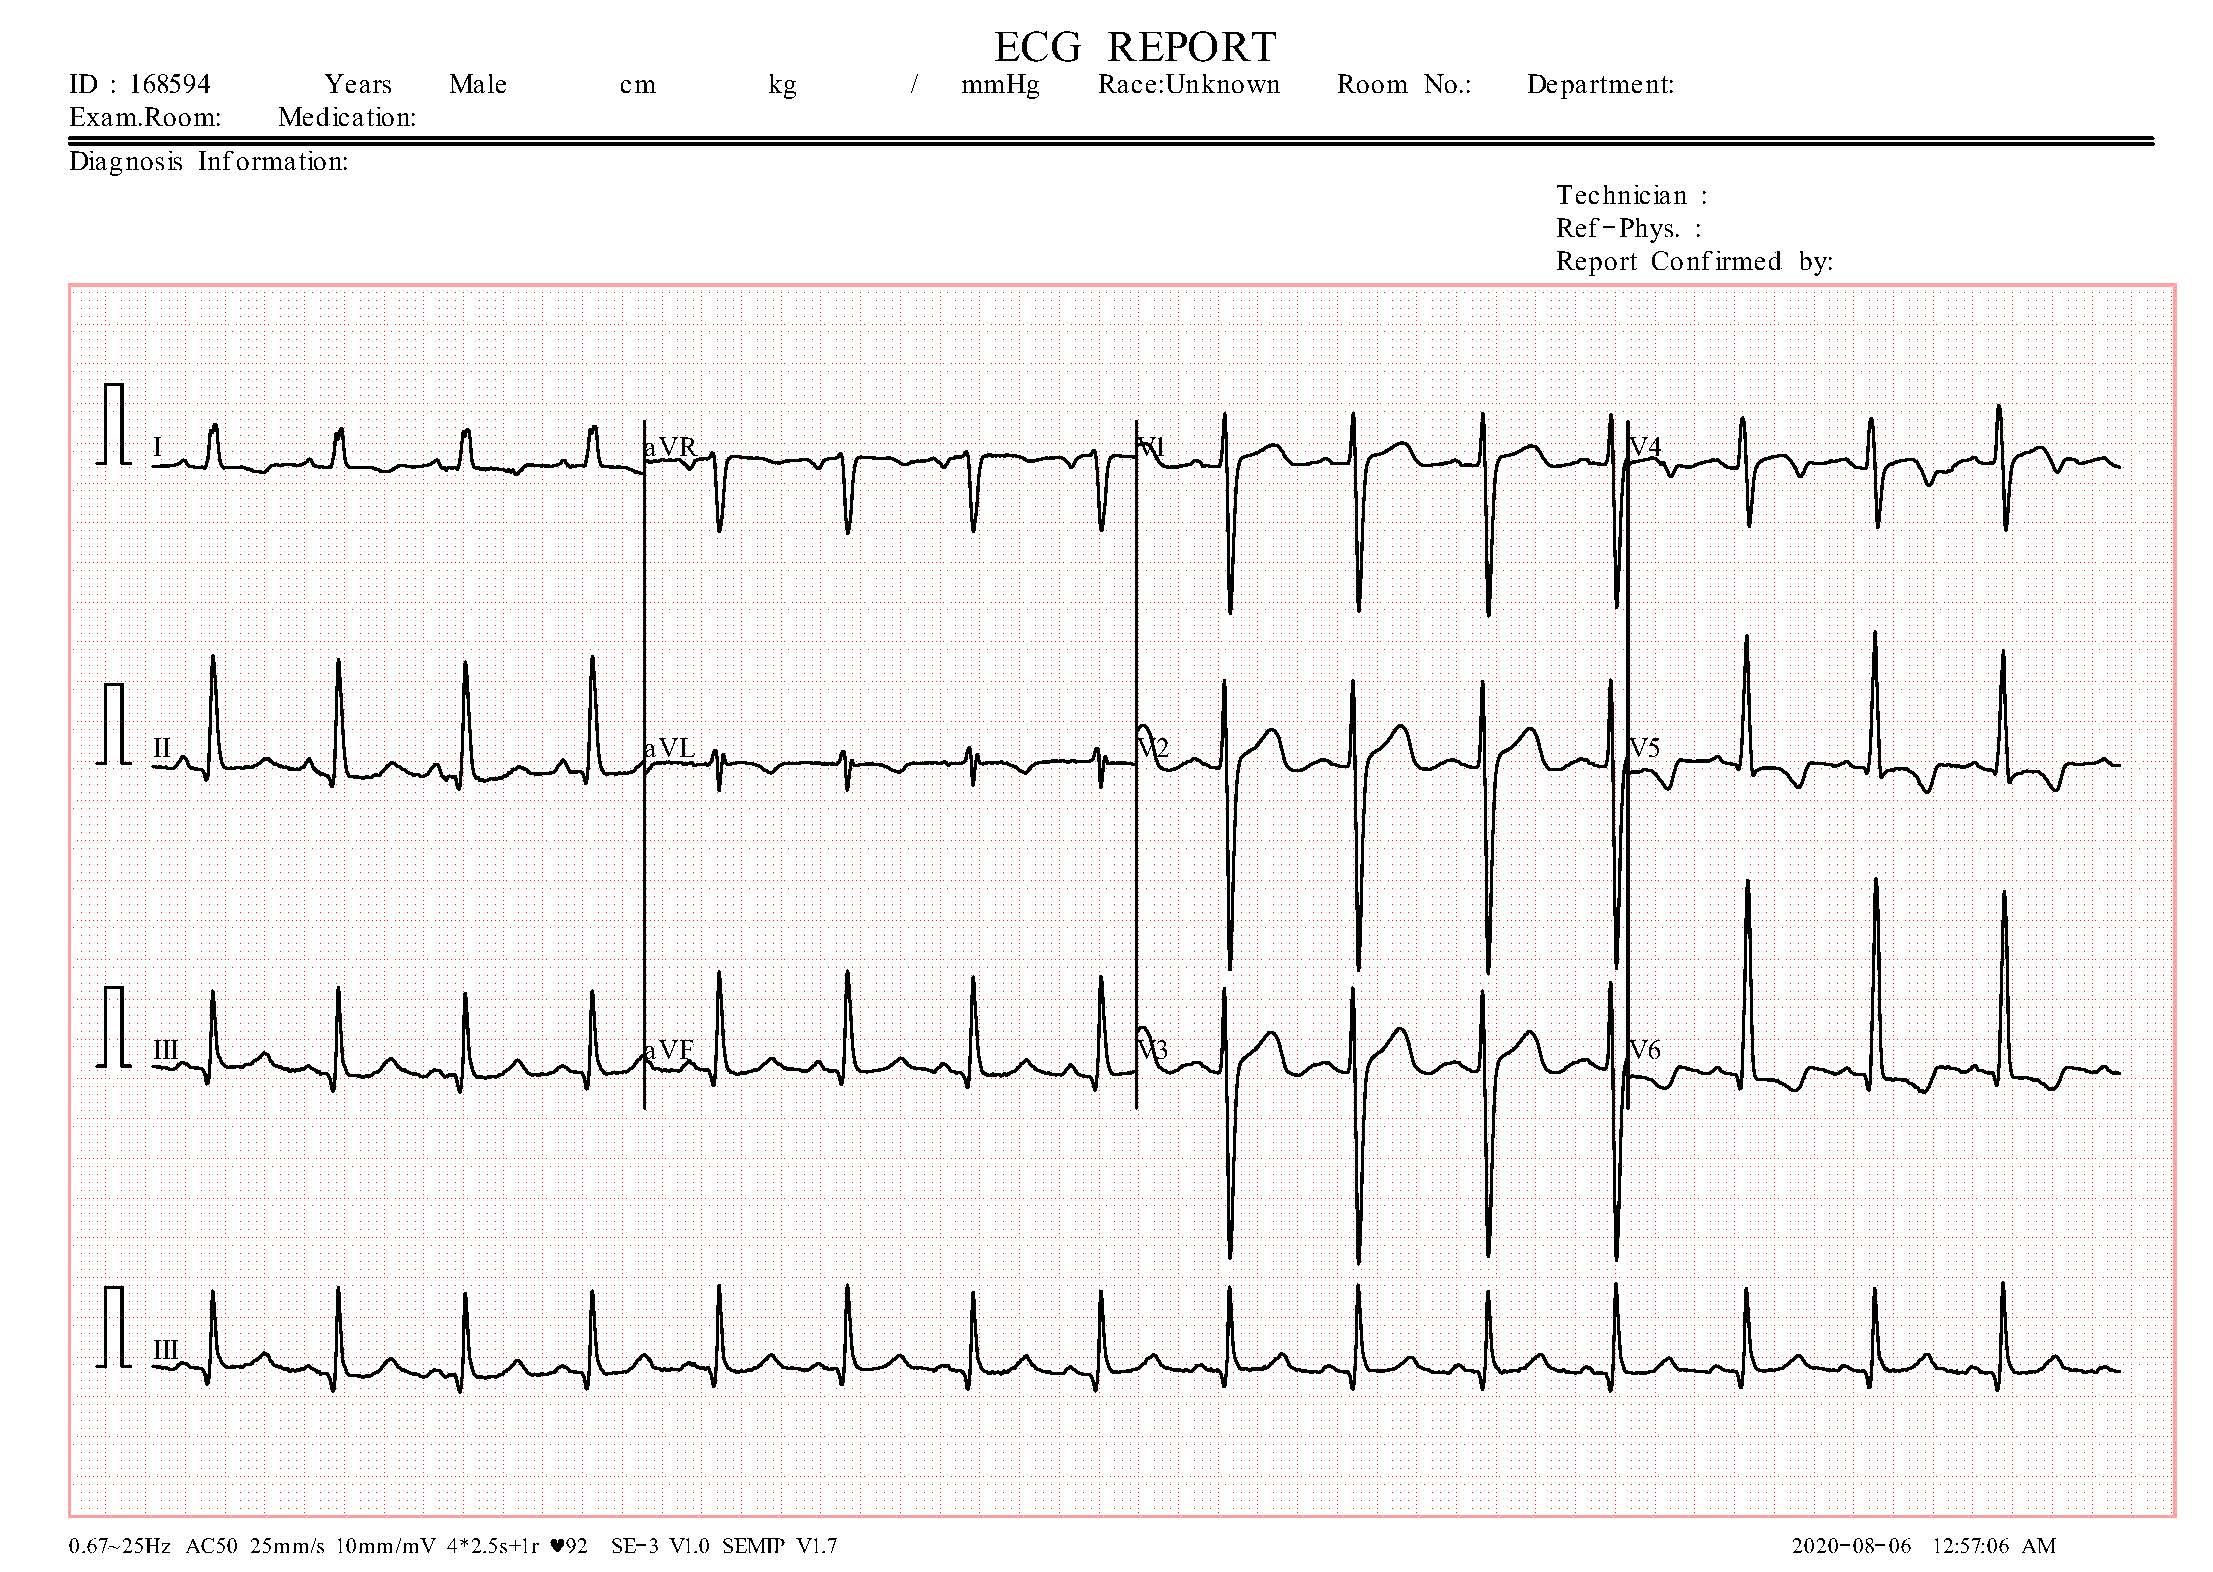

In [13]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import io
from google.colab import files
from IPython.display import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
def load_model(path):
    model = models.mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.last_channel, 1)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

print("Loading model...")
model = load_model('/content/drive/MyDrive/GNN-BC/best_mobilenetv2.pt')
print("✅ Model loaded\n")

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Predict function
def predict(img_bytes):
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()

    label = 'ECG ✅' if prob > 0.5 else 'NOT ECG ❌'
    return img, label, prob

# Upload and test
print("")
uploaded = files.upload()

for fn, content in uploaded.items():
    img, label, prob = predict(content)
    print(f"File: {fn}")
    print(f"  Prediction: {label}")
    print(f"  Confidence: {prob:.4f}\n")
    display(img)
